In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from xgboost import XGBClassifier
from imblearn import over_sampling

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
N_SEED = 19
TOP_K = 5
VERBOSE = 1
N_JOBS = 4
COLOR_MAP = "RdYlBu"
TEST_SIZE = 0.3
L_FONT = {
    "color": "darkblue",
    "size": 11
}
T_COLOR = "darkred"

np.random.seed(N_SEED)

In [3]:
# https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data
dataset = pd.read_csv("../data/creditcard.csv")

## EDA

In [4]:
dataset.head(TOP_K)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
dataset.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [7]:
dataset.isnull().values.sum()

0

In [8]:
def show_corr(features, target):
    plt.figure(figsize=(19, 15))
    features.corrwith(target).plot.bar(color="purple", grid=True)
    ax = plt.gca()
    ax.spines["bottom"].set_color(T_COLOR)
    ax.spines["top"].set_color(T_COLOR)
    ax.spines["left"].set_color(T_COLOR)
    ax.spines["right"].set_color(T_COLOR)
    ax.tick_params(axis="x", colors=T_COLOR)
    ax.tick_params(axis="y", colors=T_COLOR)
    plt.show();


def show_corr_heatmap(data):
    corr = data.corr() * 100
    plt.figure(figsize=(20, 15))
    sns.heatmap(corr, annot=True, cmap=COLOR_MAP, fmt=".2f")
    ax = plt.gca()
    ax.spines["bottom"].set_color(T_COLOR)
    ax.spines["top"].set_color(T_COLOR)
    ax.spines["left"].set_color(T_COLOR)
    ax.spines["right"].set_color(T_COLOR)
    ax.tick_params(axis="x", colors=T_COLOR)
    ax.tick_params(axis="y", colors=T_COLOR)
    plt.show();


def plot_features(x, target):
    _, col = x.shape
    for i in range(col):
        plt.scatter(x[:, i], target, color="red", s=4,)
        plt.xlabel("X: {i}".format(i=i), fontdict=L_FONT)
        plt.ylabel("Target", fontdict=L_FONT)
        ax = plt.gca()
        ax.spines["bottom"].set_color(T_COLOR)
        ax.spines["top"].set_color(None)
        ax.spines["left"].set_color(T_COLOR)
        ax.spines["right"].set_color(None)
        ax.tick_params(axis="x", colors=T_COLOR)
        ax.tick_params(axis="y", colors=T_COLOR)
        plt.show();
        plt.hist(x[:, i], color="green")
        plt.xlabel("X: {i}".format(i=i), fontdict=L_FONT)
        plt.ylabel("Population", fontdict=L_FONT)
        ax = plt.gca()
        ax.spines["bottom"].set_color(T_COLOR)
        ax.spines["top"].set_color(None)
        ax.spines["left"].set_color(T_COLOR)
        ax.spines["right"].set_color(None)
        ax.tick_params(axis="x", colors=T_COLOR)
        ax.tick_params(axis="y", colors=T_COLOR)
        plt.show();


def plot_class_dist(target):
    unique, counts = np.unique(target, return_counts=True)
    plt.bar(unique, counts, color="darkblue",)
    plt.xlabel("Class", fontdict=L_FONT)
    plt.ylabel("Population", fontdict=L_FONT)
    ax = plt.gca()
    ax.set_xticks(ticks=unique, labels=unique)
    ax.spines["bottom"].set_color(T_COLOR)
    ax.spines["top"].set_color(None)
    ax.spines["left"].set_color(T_COLOR)
    ax.spines["right"].set_color(None)
    ax.tick_params(axis="x", colors=T_COLOR)
    ax.tick_params(axis="y", colors=T_COLOR)
    plt.show();


def plot_roc(fpr, tpr, roc_auc):
    plt.plot(fpr, tpr, color="#1ecbe1", label="AUC = %0.4f" % roc_auc,)
    plt.legend(loc = "lower right")
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel("TPR", fontdict=L_FONT)
    plt.xlabel("FPR", fontdict=L_FONT)
    ax = plt.gca()
    ax.set_title("Receiver Operating Characteristic", fontdict={"color": "darkblue"})
    ax.spines["bottom"].set_color(T_COLOR)
    ax.spines["top"].set_color(None)
    ax.spines["left"].set_color(T_COLOR)
    ax.spines["right"].set_color(None)
    ax.tick_params(axis="x", colors=T_COLOR)
    ax.tick_params(axis="y", colors=T_COLOR)
    plt.show();


def plot_classification(y_true, y_pred):
    precision, recall, f1, support = metrics.precision_recall_fscore_support(y_true, y_pred)
    sns.heatmap(
        (precision*100, recall*100, f1*100),
        annot=True, cmap=COLOR_MAP,
        fmt=".4f",
        yticklabels=("precision", "recall", "f1")
    )
    ax = plt.gca()
    ax.set_title("Classification Report", fontdict=L_FONT)
    ax.tick_params(axis="x", colors=T_COLOR)
    ax.tick_params(axis="y", colors=T_COLOR)
    plt.show();

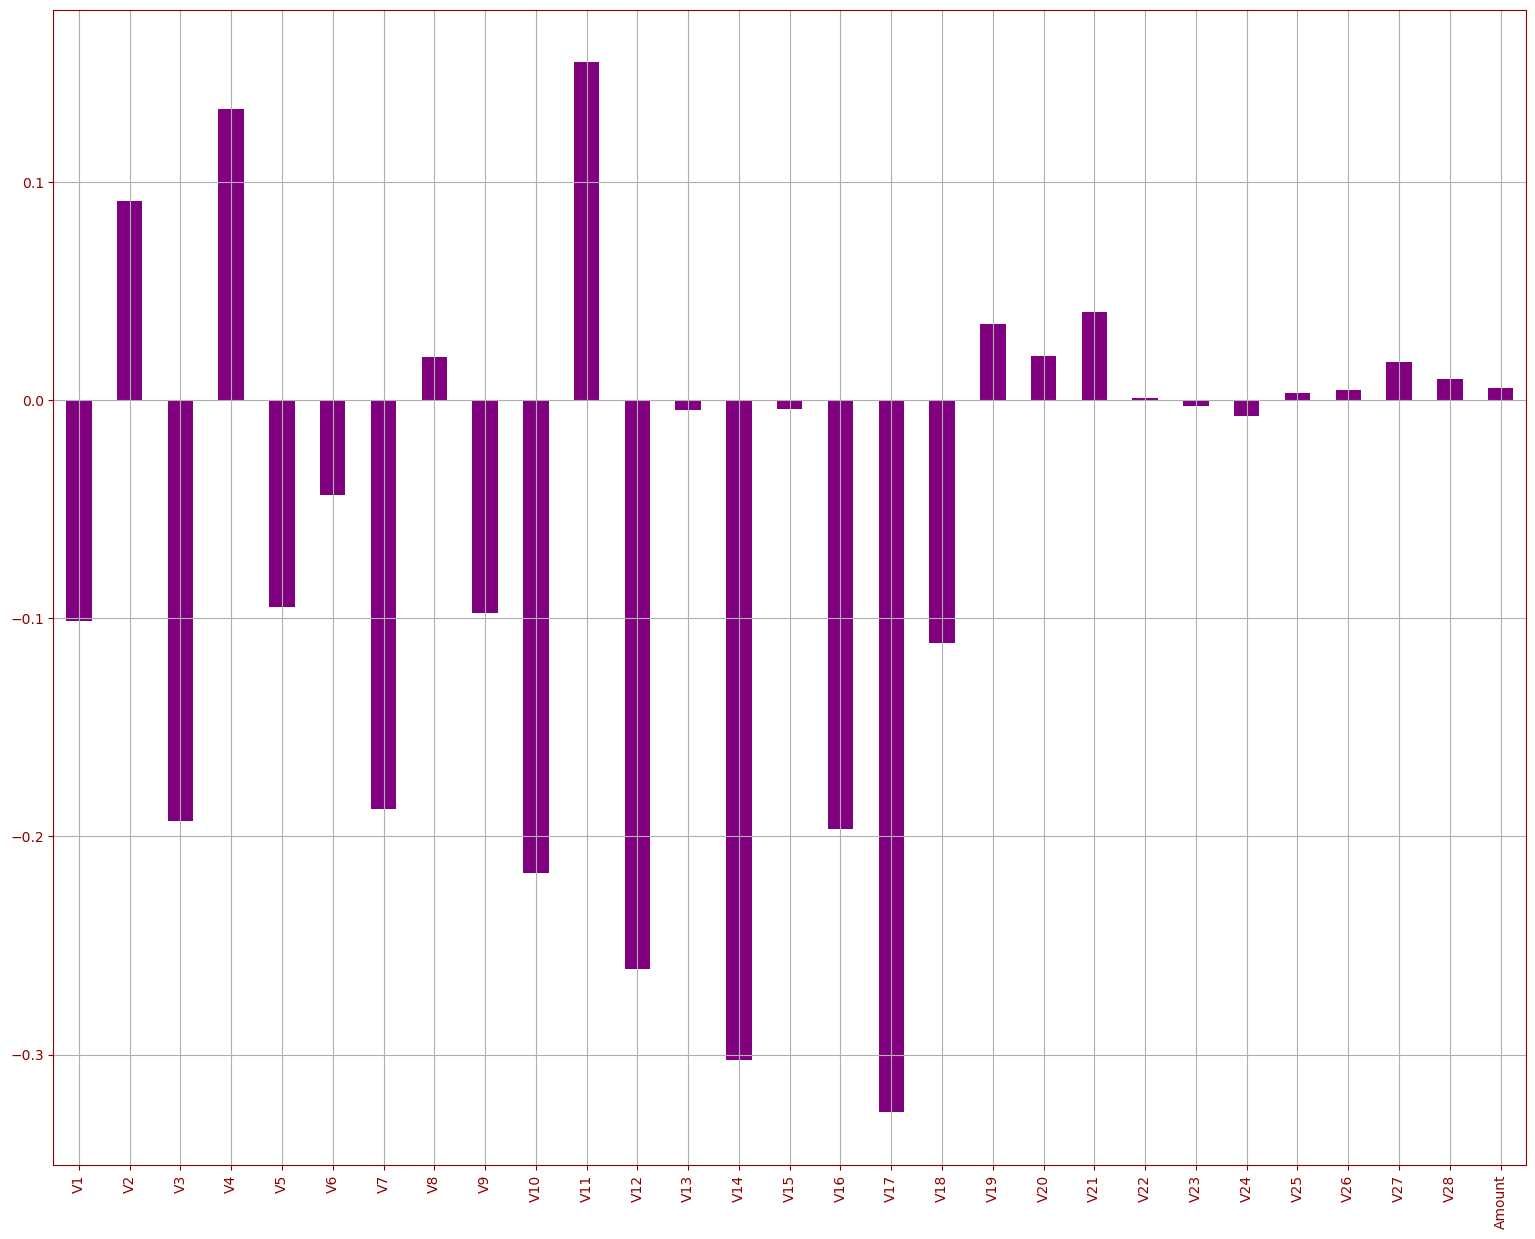

In [9]:
X_df = dataset.drop(columns=["Class", "Time"], axis=1)
y_df = dataset["Class"]
show_corr(X_df, y_df)

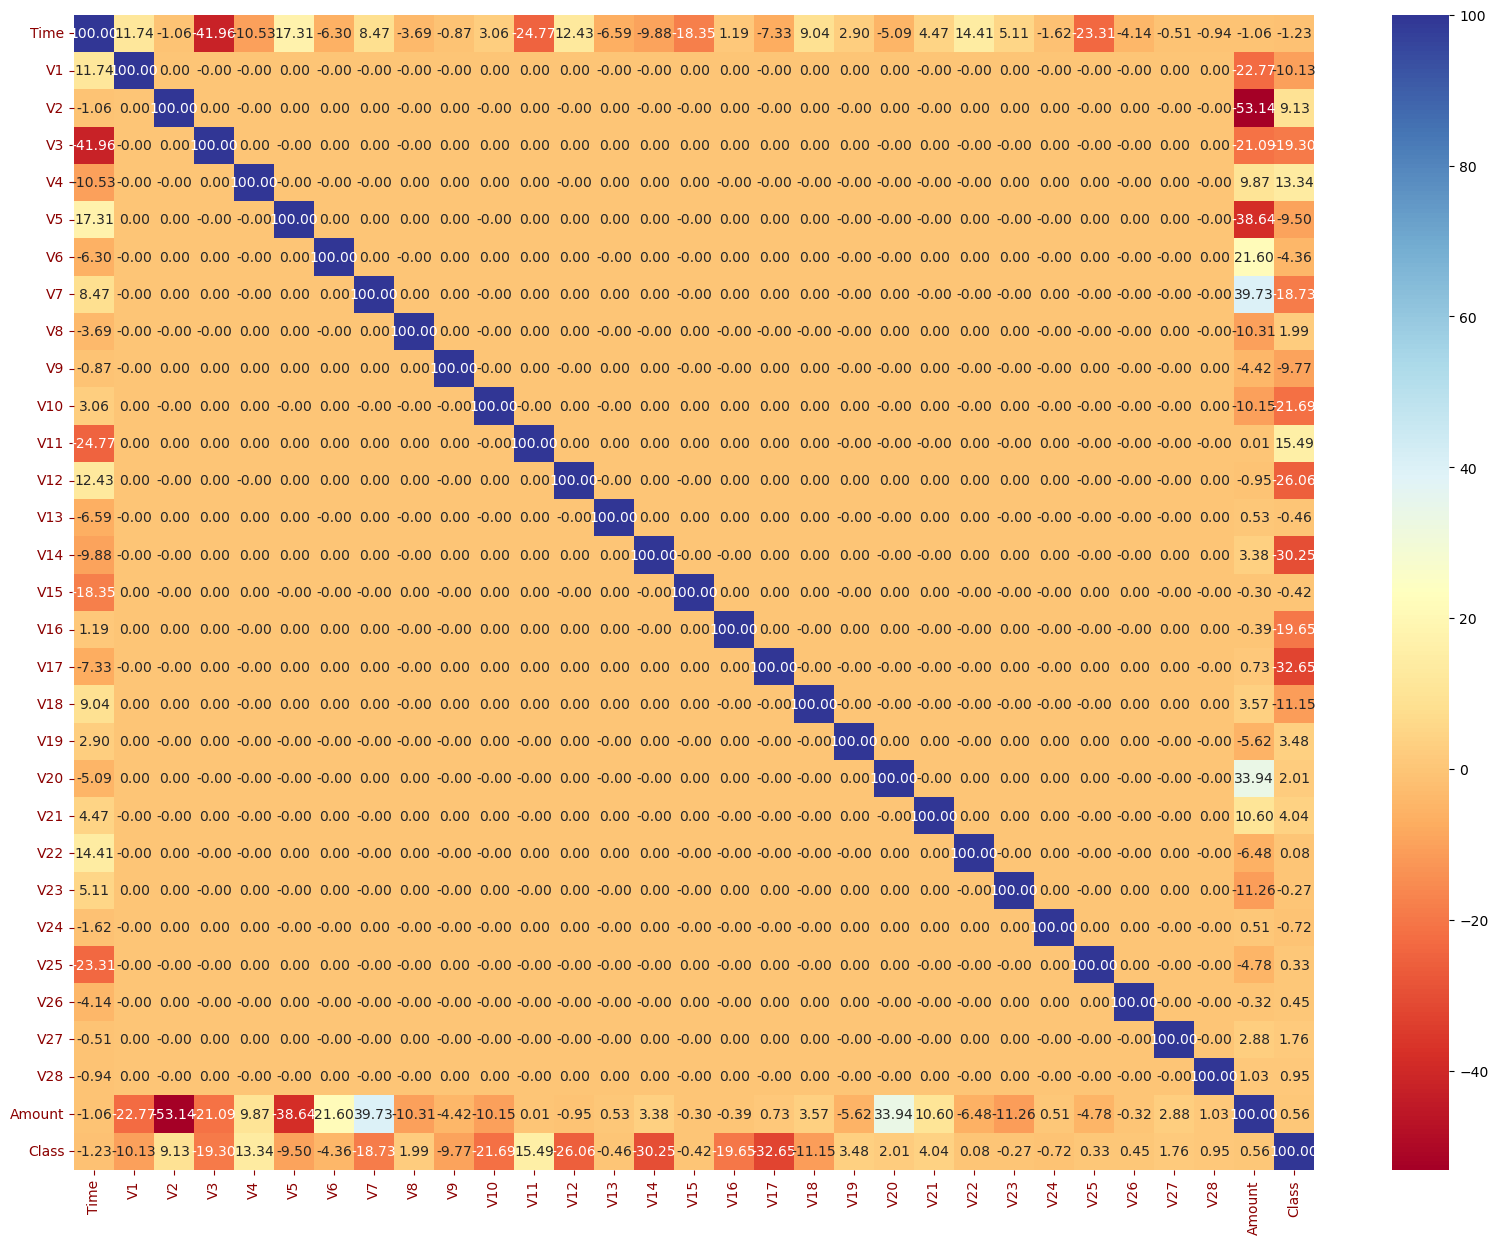

In [10]:
show_corr_heatmap(dataset)

In [11]:
X = np.array(X_df)
y = np.array(y_df)

In [12]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [13]:
_, counts = np.unique(y, return_counts=True)
class_ratio = counts[0]/counts[1]
class_ratio

577.8760162601626

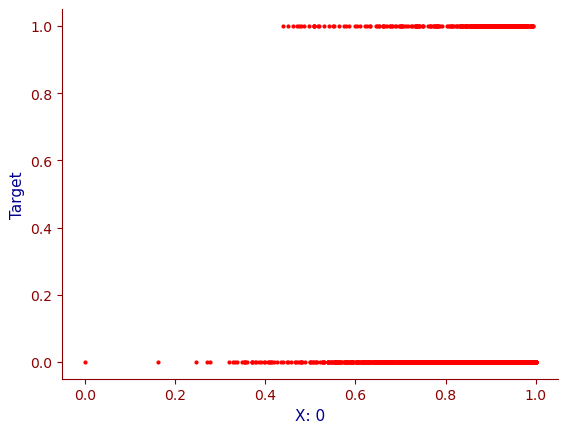

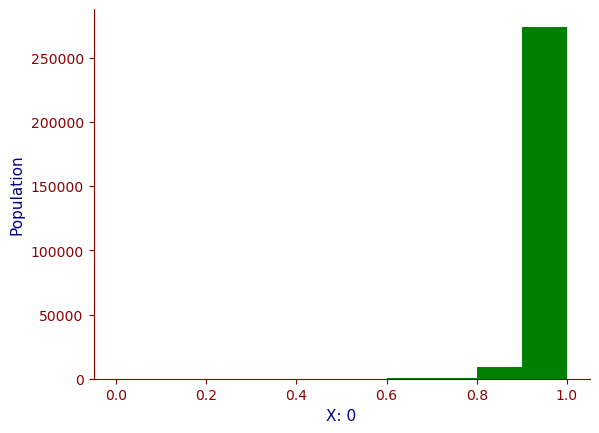

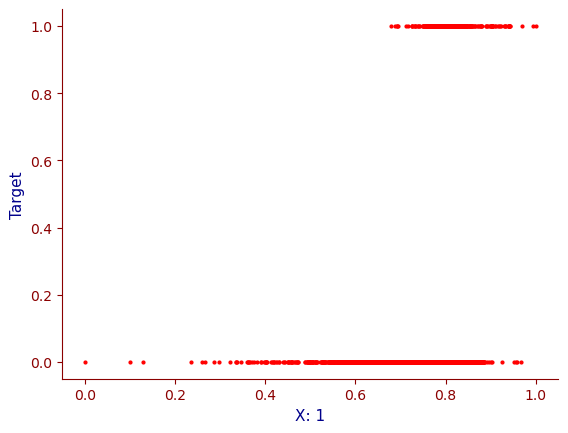

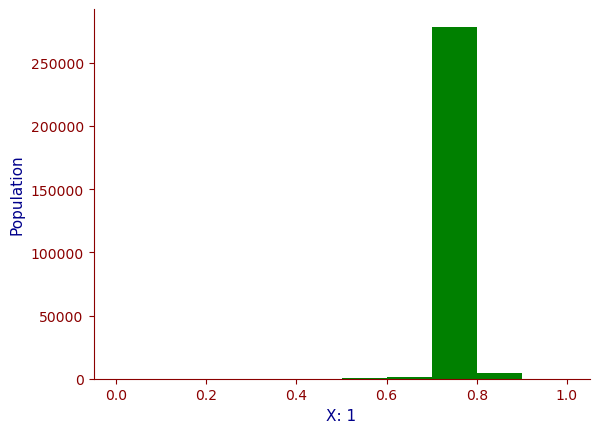

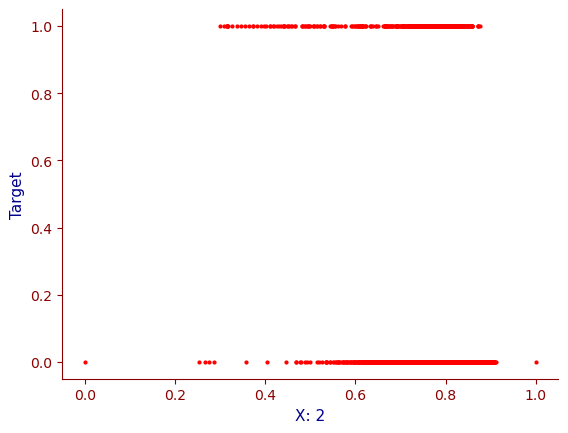

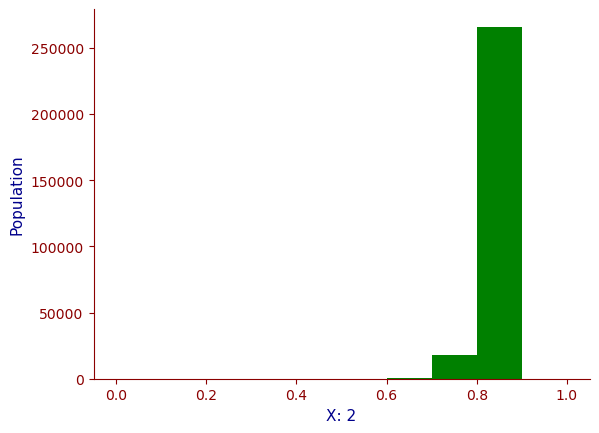

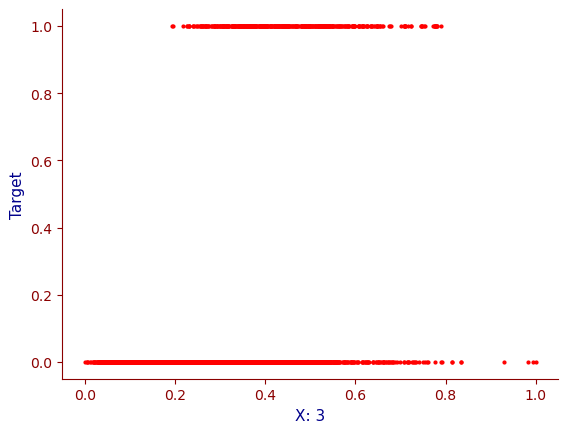

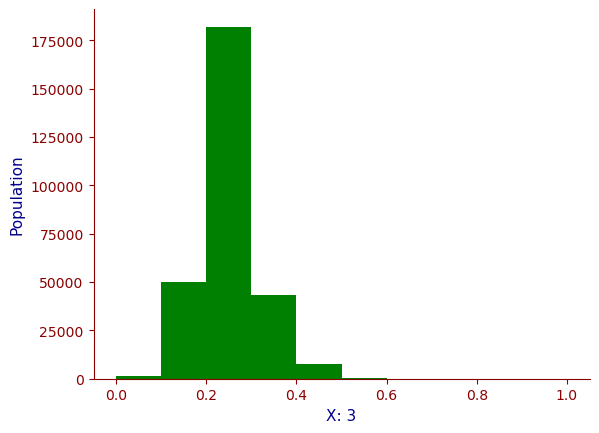

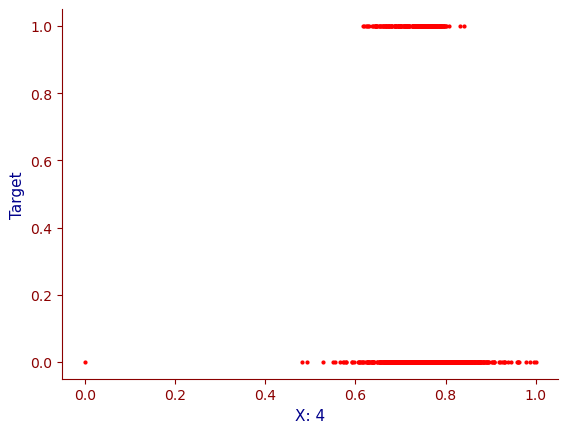

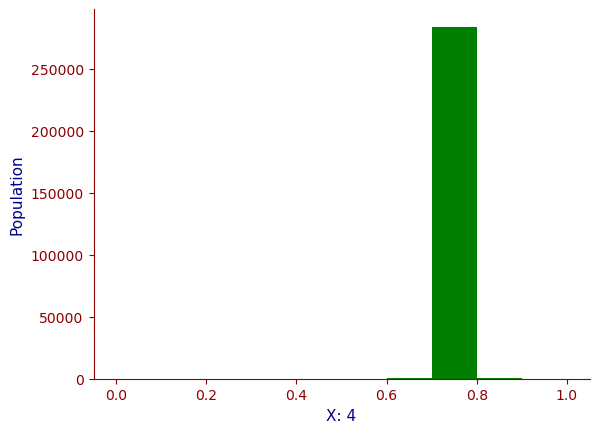

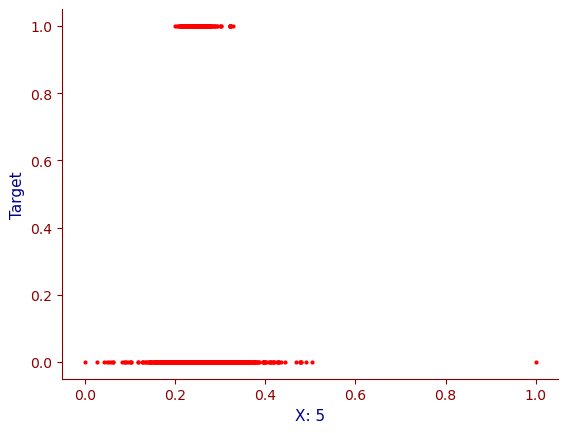

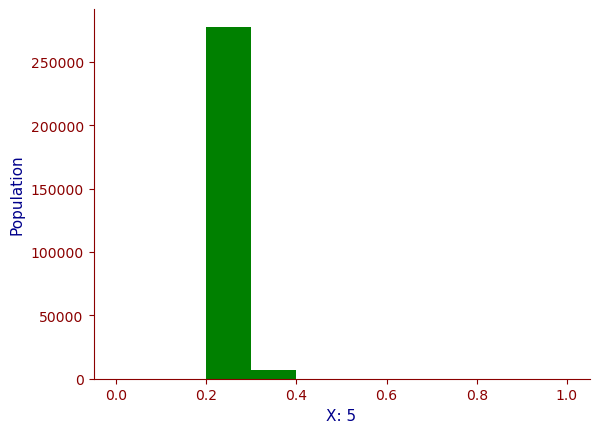

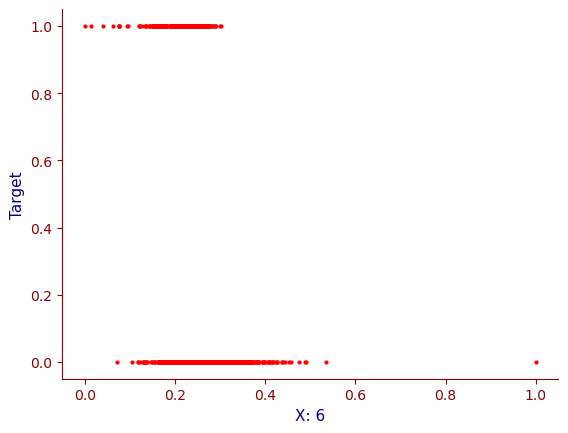

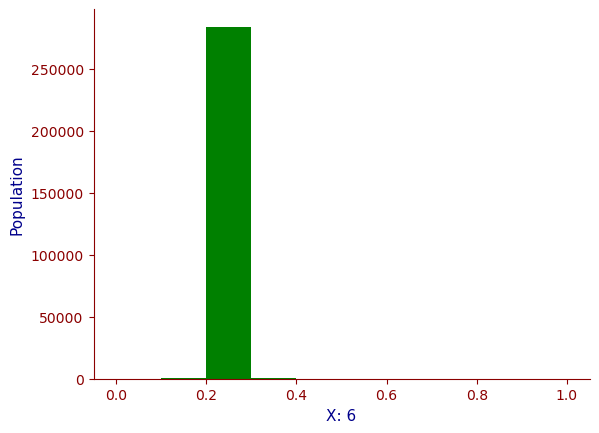

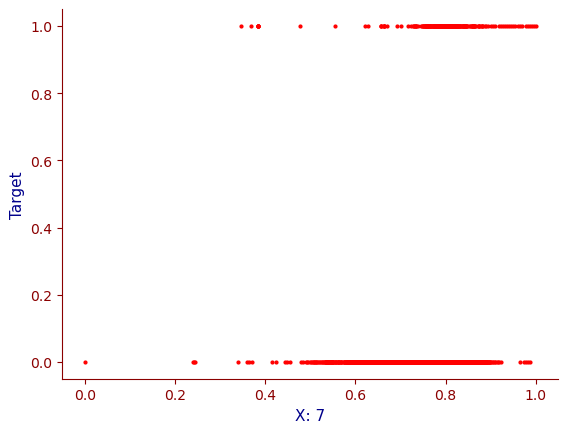

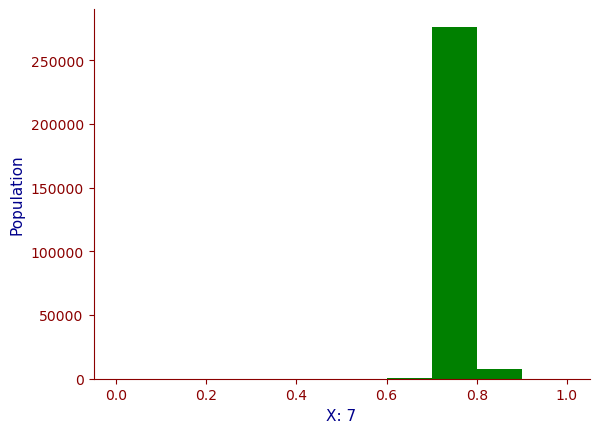

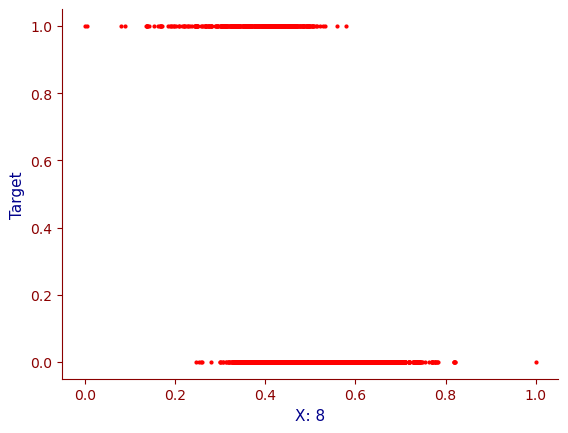

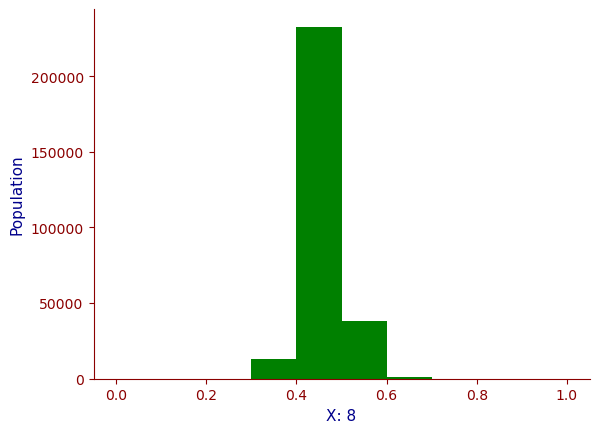

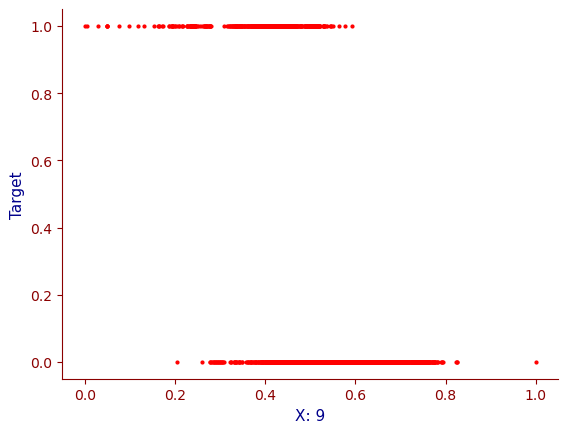

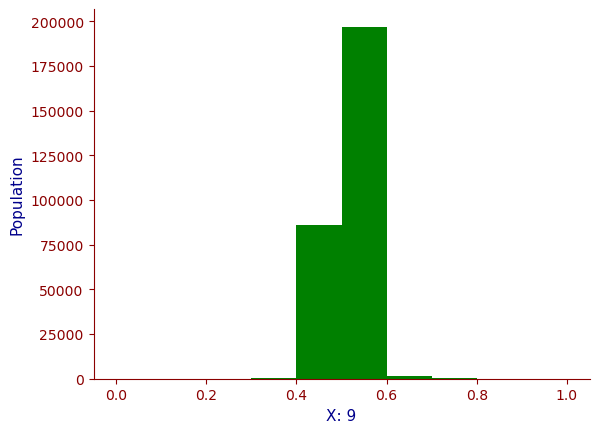

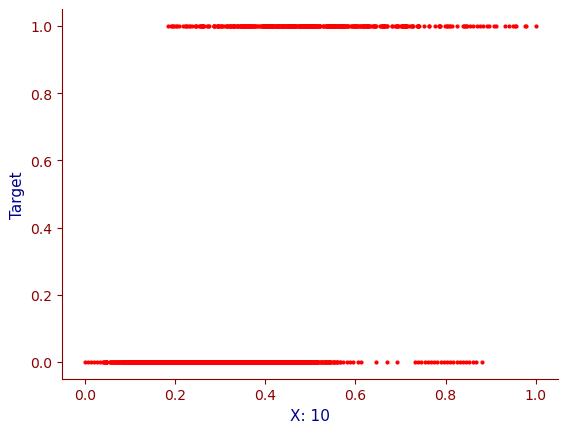

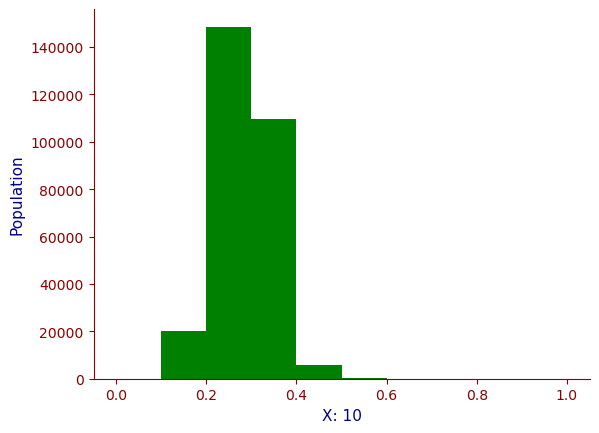

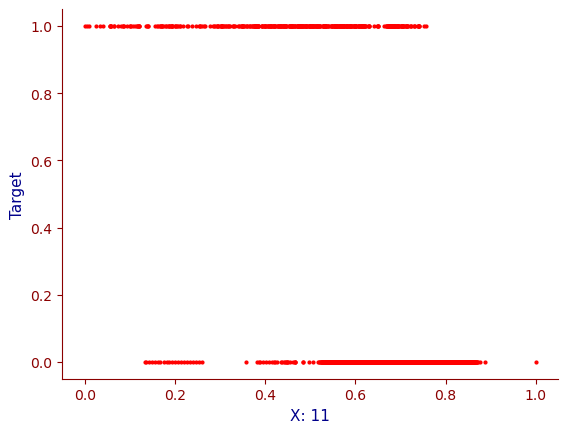

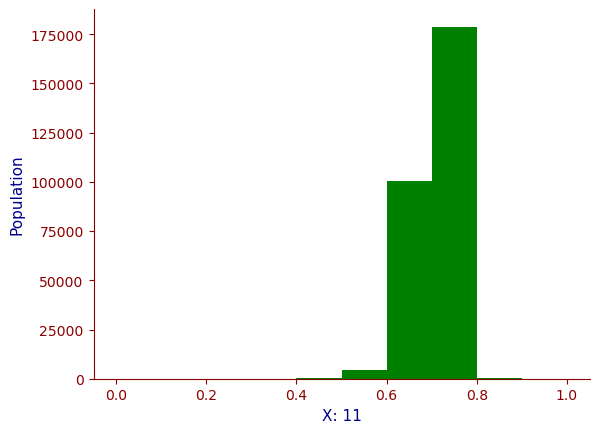

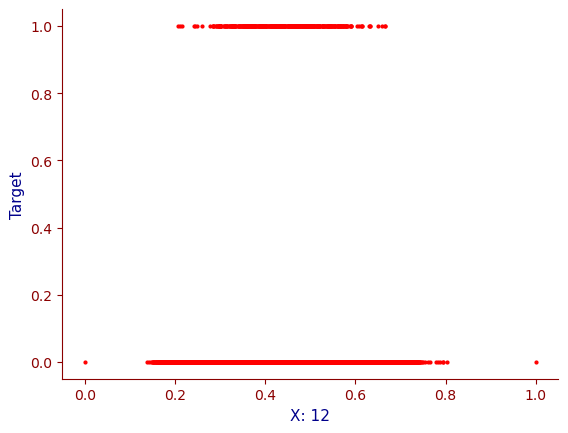

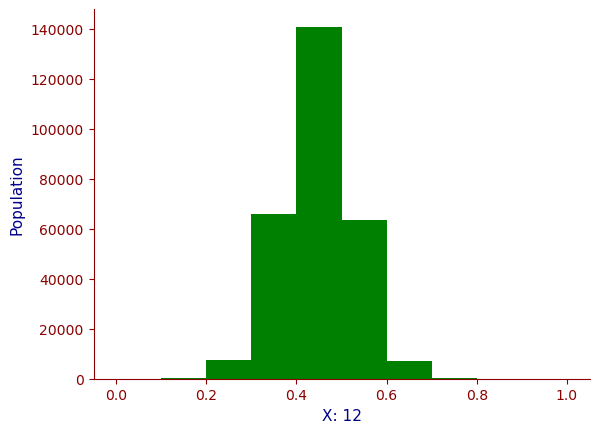

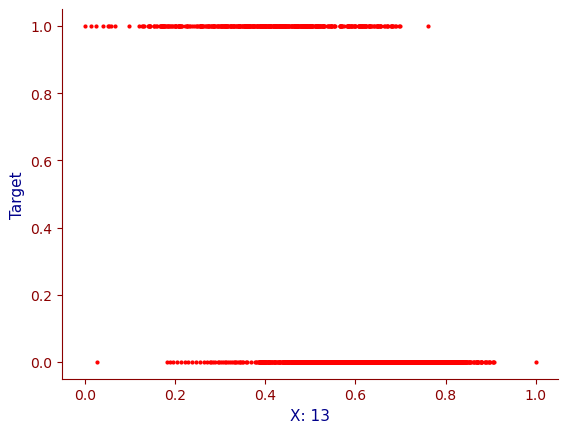

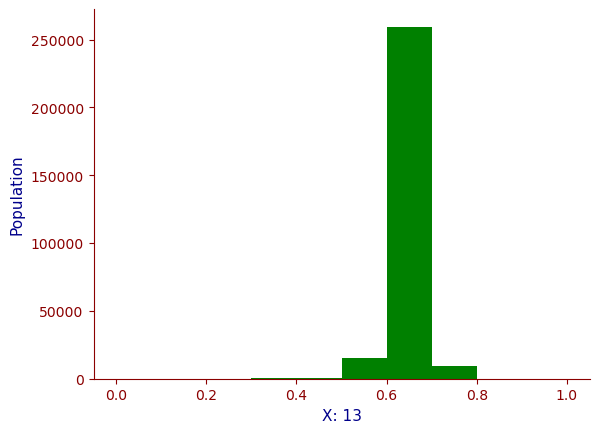

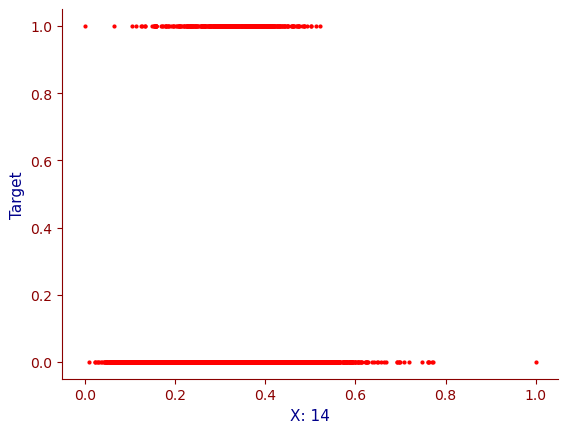

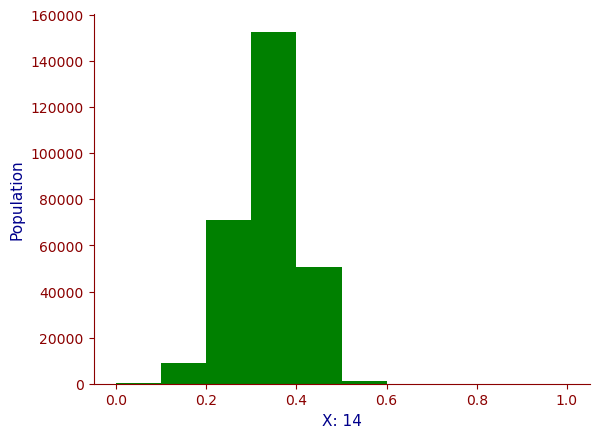

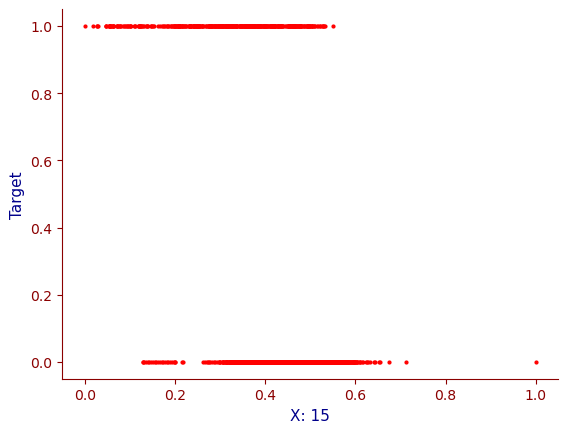

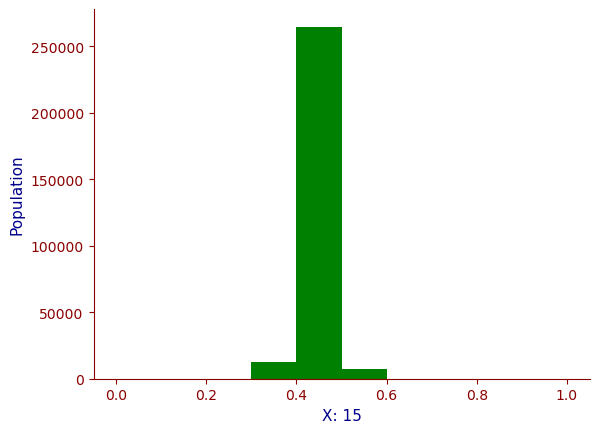

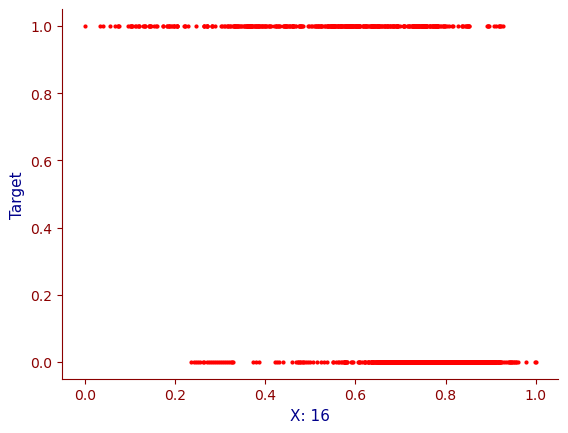

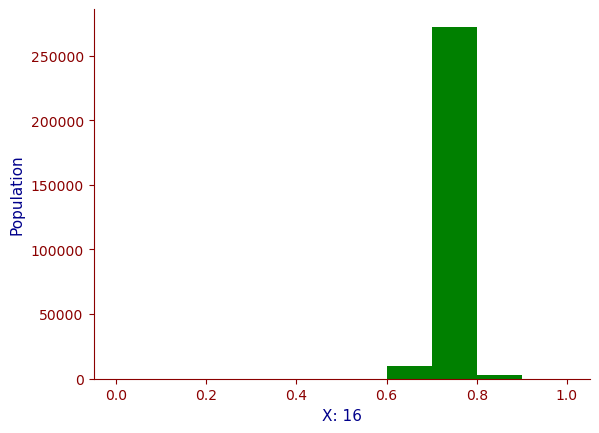

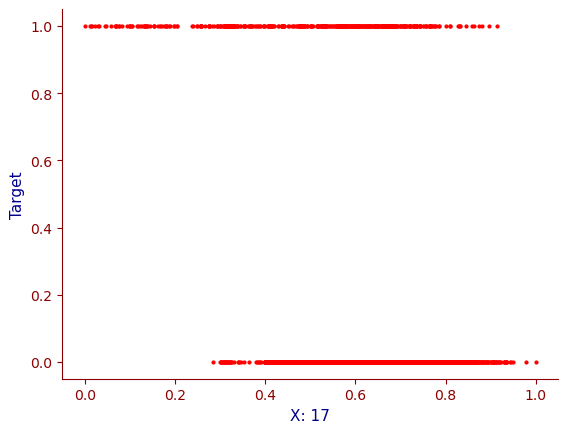

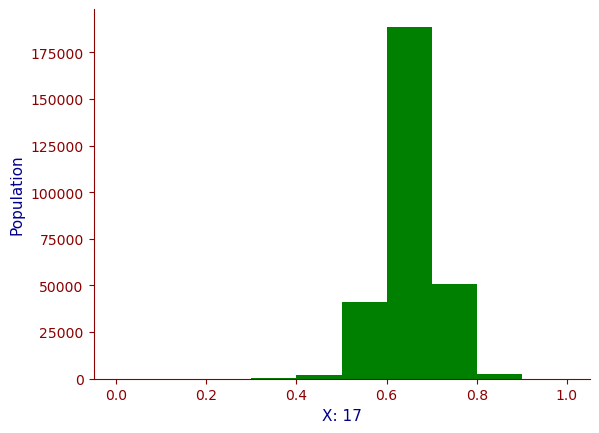

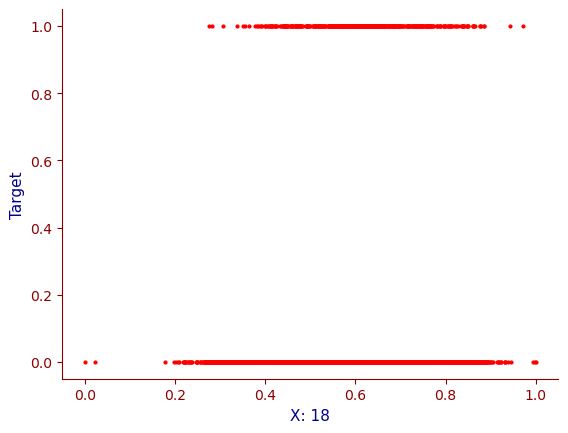

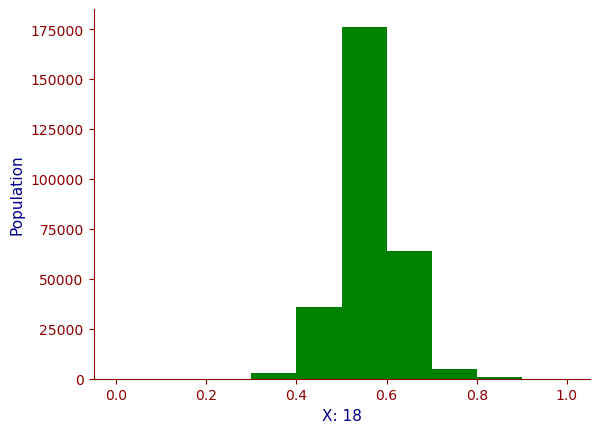

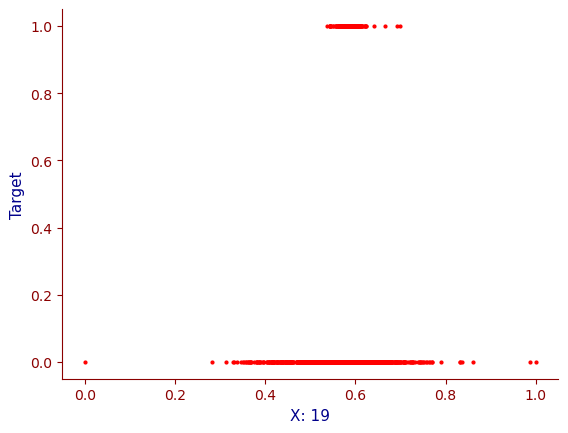

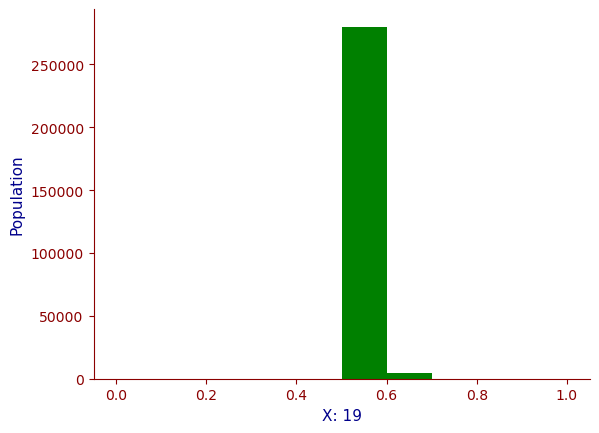

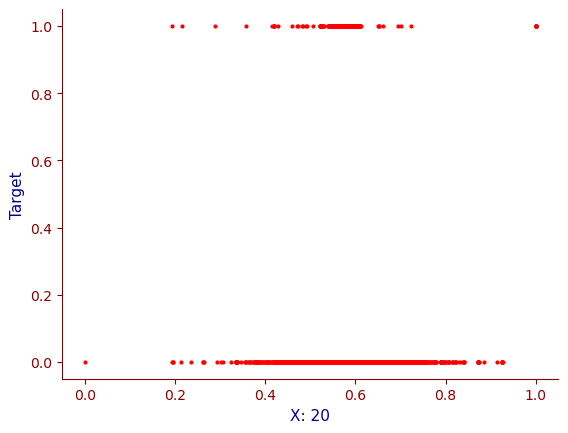

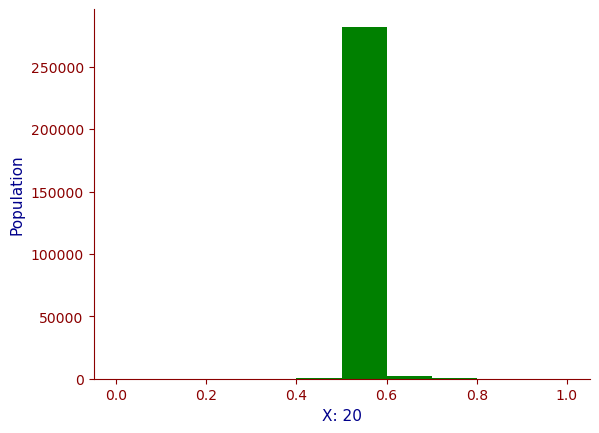

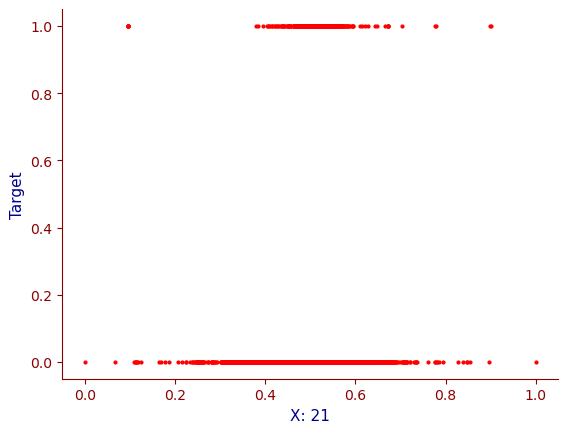

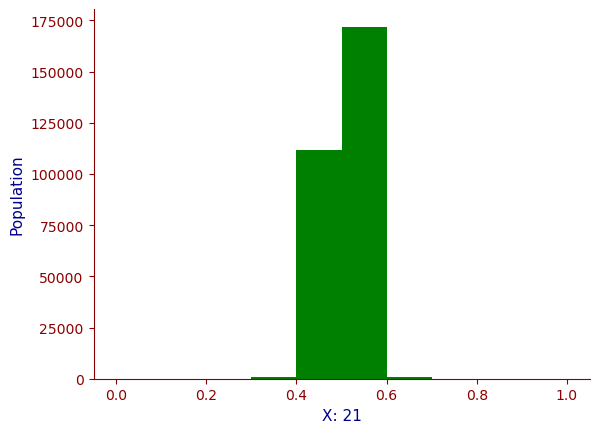

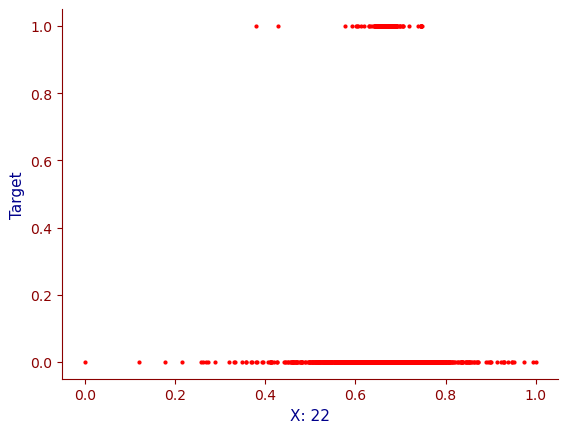

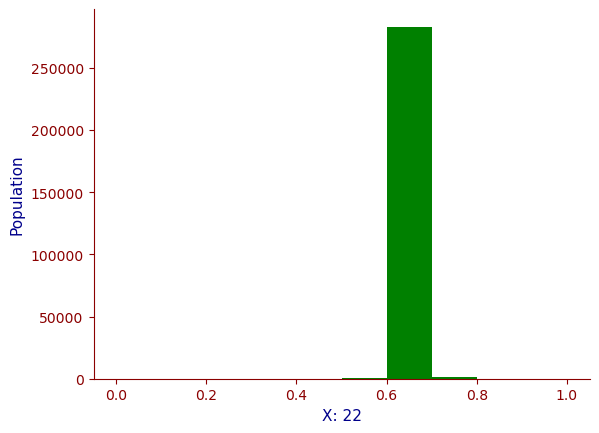

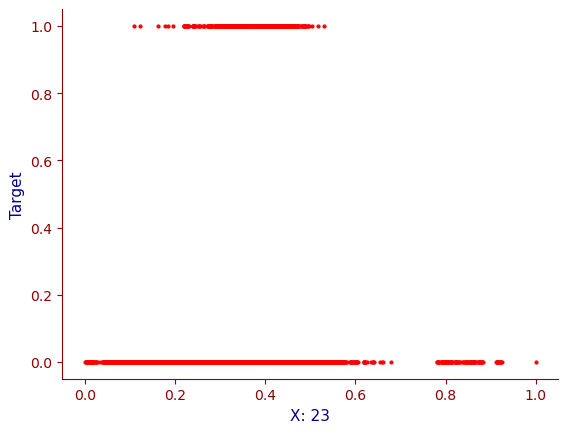

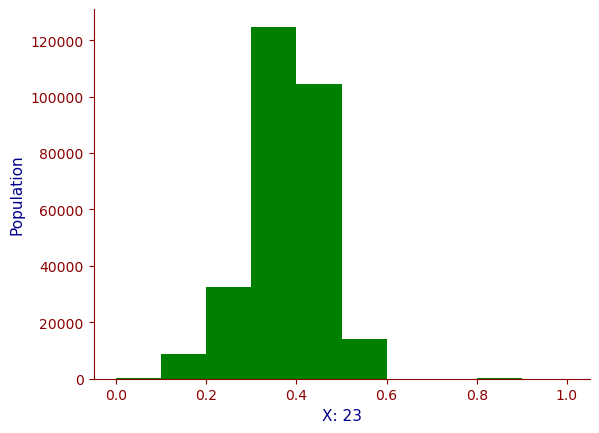

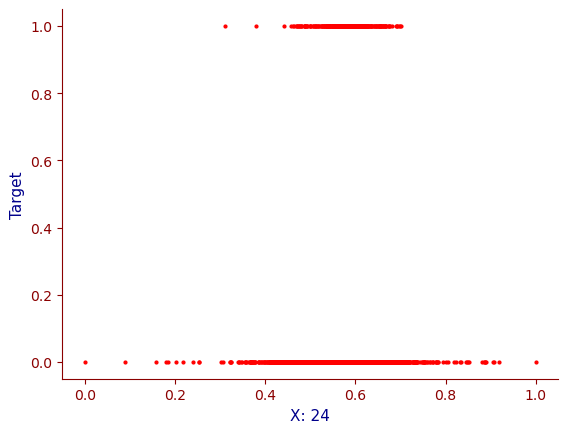

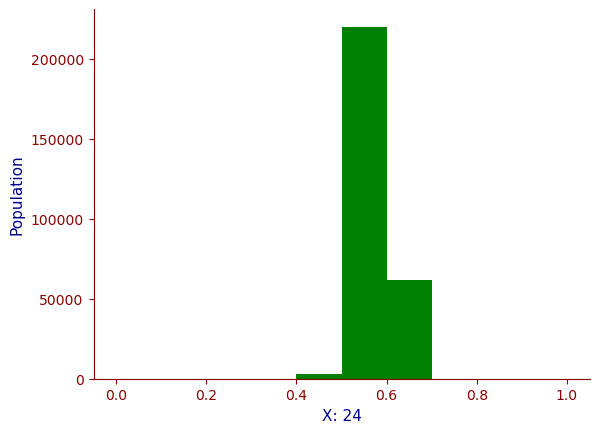

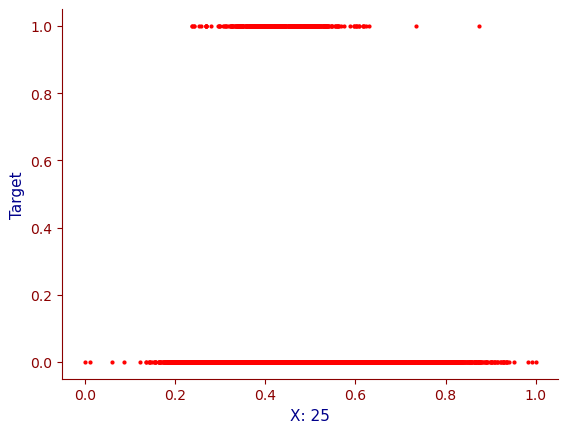

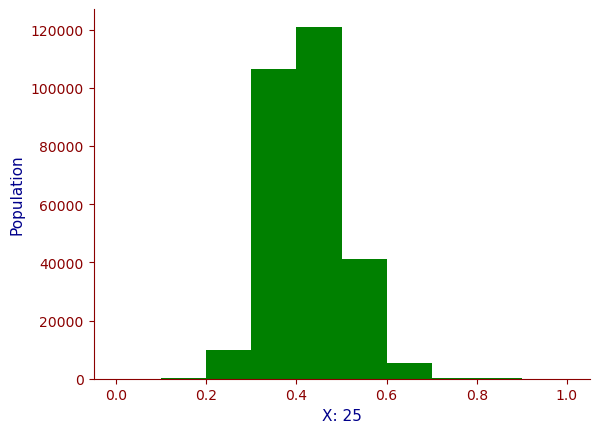

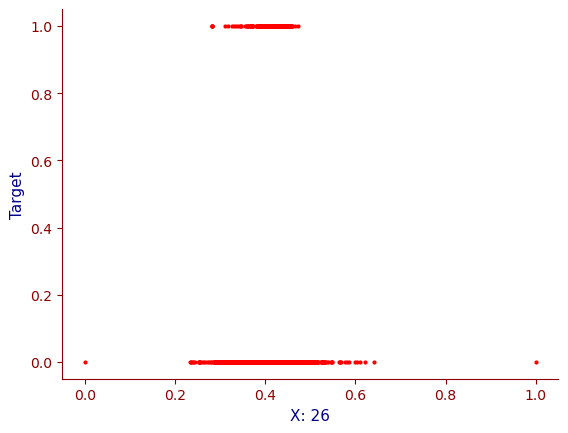

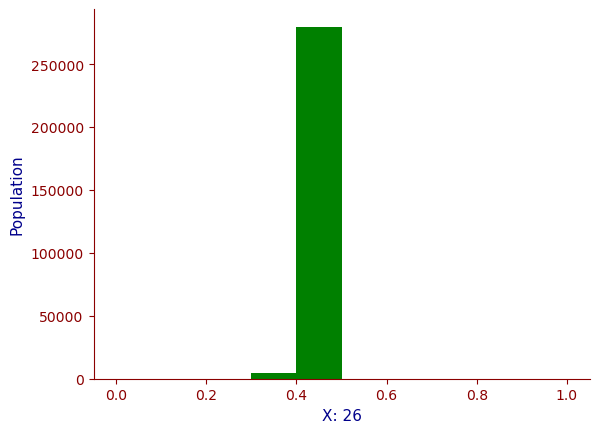

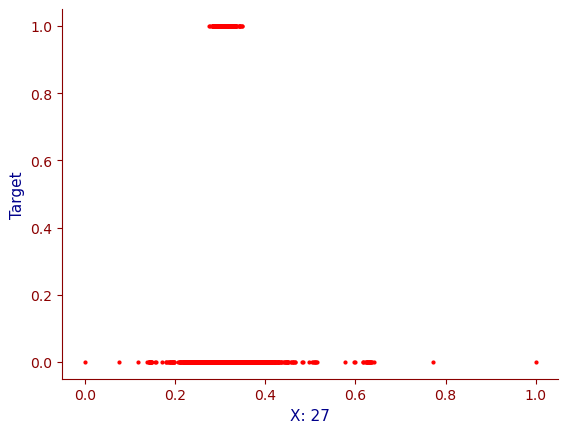

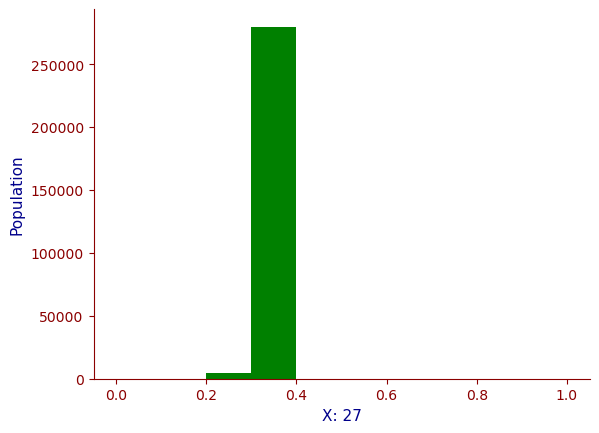

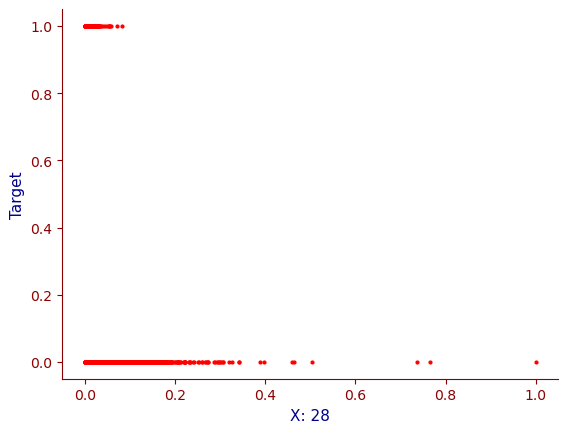

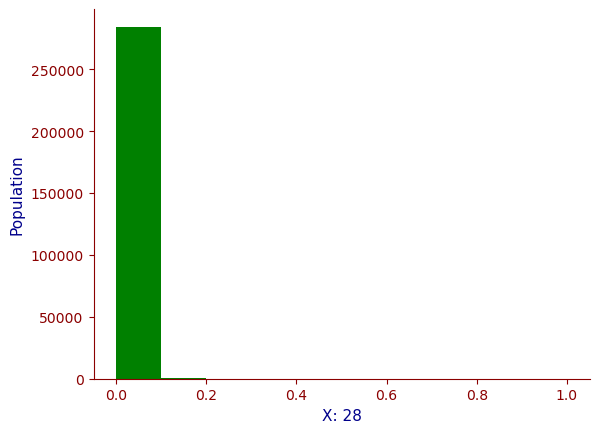

In [14]:
plot_features(X, y)

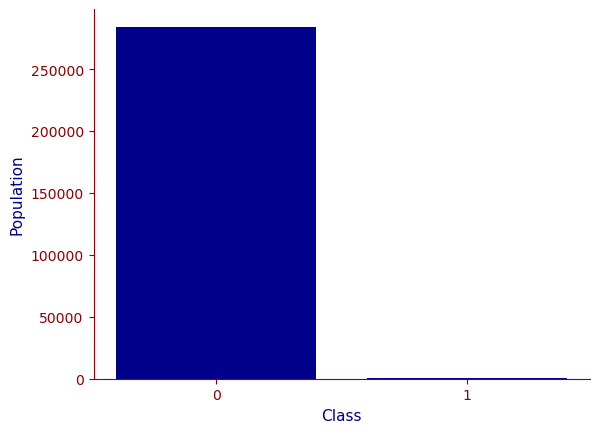

In [15]:
plot_class_dist(y)

In [16]:
X0_train, X0_test, y0_train, y0_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=N_SEED,
    shuffle=True,
    stratify=y
)

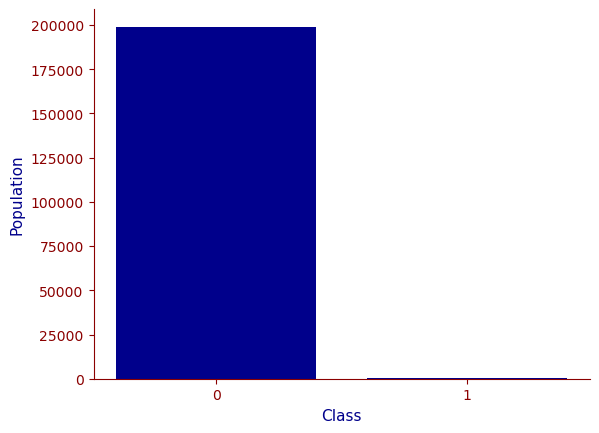

In [17]:
plot_class_dist(y0_train)

## Over Sampling train dataset

In [18]:
over_sampler = over_sampling.BorderlineSMOTE(
    sampling_strategy="minority",
    random_state=N_SEED,
)

X_train, y_train = over_sampler.fit_resample(X0_train, y0_train)
# X_train, y_train = X0_train, y0_train
X_test, y_test = X0_test, y0_test

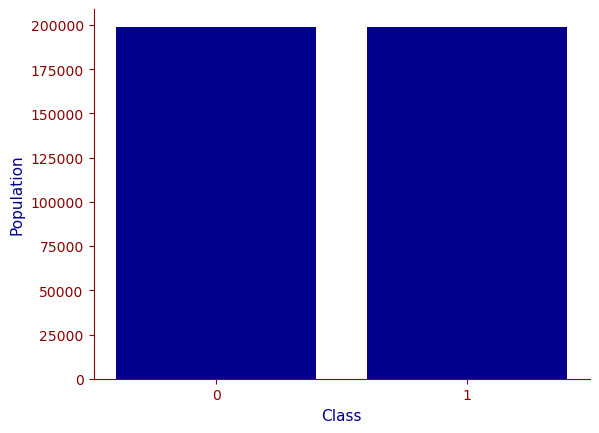

In [19]:
plot_class_dist(y_train)

## Logistic Regression

In [20]:
param_grid_LGR = {
    "solver": ["newton-cholesky"],
    "penalty": ["l2", None],
}

grid_search_cv_LGR = GridSearchCV(
    LogisticRegression(
        n_jobs=N_JOBS,
        random_state=N_SEED,
        verbose=VERBOSE,
    ),
    param_grid=param_grid_LGR,
    refit=True,
)

pipeline_LGR = make_pipeline(
    grid_search_cv_LGR,
)

pipeline_LGR.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Newton iter=1
  Check Convergence
    1. max |gradient| 0.012862302522529647 <= 0.0001
Newton iter=2
  Check Convergence
    1. max |gradient| 0.005971794293476187 <= 0.0001
Newton iter=3
  Check Convergence
    1. max |gradient| 0.0019525308466644656 <= 0.0001
Newton iter=4
  Check Convergence
    1. max |gradient| 0.0006160589839387479 <= 0.0001
Newton iter=5
  Check Convergence
    1. max |gradient| 0.00020945820061309432 <= 0.0001
Newton iter=6
  Check Convergence
    1. max |gradient| 0.00012318081020309724 <= 0.0001
Newton iter=7
  Check Convergence
    1. max |gradient| 3.6930015005008426e-05 <= 0.0001
    2. Newton decrement 0.0001868948396765481 <= 0.0001
Newton iter=8
  Check Convergence
    1. max |gradient| 1.6053043218924564e-06 <= 0.0001
    2. Newton decrement 5.290834673467465e-06 <= 0.0001
  Solver did converge at loss = 0.03087363984699721.


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Newton iter=1
  Check Convergence
    1. max |gradient| 0.012938801837076472 <= 0.0001
Newton iter=2
  Check Convergence
    1. max |gradient| 0.006054577068910162 <= 0.0001
Newton iter=3
  Check Convergence
    1. max |gradient| 0.0019782292501356194 <= 0.0001
Newton iter=4
  Check Convergence
    1. max |gradient| 0.0006262541027137737 <= 0.0001
Newton iter=5
  Check Convergence
    1. max |gradient| 0.00021361164295210936 <= 0.0001
Newton iter=6
  Check Convergence
    1. max |gradient| 0.00013002892957017119 <= 0.0001
Newton iter=7
  Check Convergence
    1. max |gradient| 3.715338967583202e-05 <= 0.0001
    2. Newton decrement 0.00017419904293354213 <= 0.0001
Newton iter=8
  Check Convergence
    1. max |gradient| 1.522031065861421e-06 <= 0.0001
    2. Newton decrement 4.689027407966549e-06 <= 0.0001
  Solver did converge at loss = 0.031993800491218936.


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Newton iter=1
  Check Convergence
    1. max |gradient| 0.01296169151770005 <= 0.0001
Newton iter=2
  Check Convergence
    1. max |gradient| 0.006090826918057059 <= 0.0001
Newton iter=3
  Check Convergence
    1. max |gradient| 0.0019859403055063124 <= 0.0001
Newton iter=4
  Check Convergence
    1. max |gradient| 0.0006335164470439512 <= 0.0001
Newton iter=5
  Check Convergence
    1. max |gradient| 0.00021719027225440362 <= 0.0001
Newton iter=6
  Check Convergence
    1. max |gradient| 0.0001349813904487835 <= 0.0001
Newton iter=7
  Check Convergence
    1. max |gradient| 3.8799892009125424e-05 <= 0.0001
    2. Newton decrement 0.00018238756236909368 <= 0.0001
Newton iter=8
  Check Convergence
    1. max |gradient| 1.6208667563635424e-06 <= 0.0001
    2. Newton decrement 5.197508776154947e-06 <= 0.0001
  Solver did converge at loss = 0.03181040142095566.


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Newton iter=1
  Check Convergence
    1. max |gradient| 0.012914207043986787 <= 0.0001
Newton iter=2
  Check Convergence
    1. max |gradient| 0.006064989432796233 <= 0.0001
Newton iter=3
  Check Convergence
    1. max |gradient| 0.0019757981303763937 <= 0.0001
Newton iter=4
  Check Convergence
    1. max |gradient| 0.000624062806748024 <= 0.0001
Newton iter=5
  Check Convergence
    1. max |gradient| 0.00021290412099249766 <= 0.0001
Newton iter=6
  Check Convergence
    1. max |gradient| 0.00012789570984963355 <= 0.0001
Newton iter=7
  Check Convergence
    1. max |gradient| 3.7504001399756286e-05 <= 0.0001
    2. Newton decrement 0.0001797593304106647 <= 0.0001
Newton iter=8
  Check Convergence
    1. max |gradient| 1.5893898483863487e-06 <= 0.0001
    2. Newton decrement 5.08713985288977e-06 <= 0.0001
  Solver did converge at loss = 0.03172051447012379.


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Newton iter=1
  Check Convergence
    1. max |gradient| 0.012960902673794813 <= 0.0001
Newton iter=2
  Check Convergence
    1. max |gradient| 0.006088893122717421 <= 0.0001
Newton iter=3
  Check Convergence
    1. max |gradient| 0.0019879722821731826 <= 0.0001
Newton iter=4
  Check Convergence
    1. max |gradient| 0.000637690079292651 <= 0.0001
Newton iter=5
  Check Convergence
    1. max |gradient| 0.00022496575881644727 <= 0.0001
Newton iter=6
  Check Convergence
    1. max |gradient| 0.00015201683209553412 <= 0.0001
Newton iter=7
  Check Convergence
    1. max |gradient| 4.536096041556049e-05 <= 0.0001
    2. Newton decrement 0.00021468900591743912 <= 0.0001
Newton iter=8
  Check Convergence
    1. max |gradient| 2.1124551632618134e-06 <= 0.0001
    2. Newton decrement 7.131149405421846e-06 <= 0.0001
  Solver did converge at loss = 0.03108548757372565.


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Newton iter=1
  Check Convergence
    1. max |gradient| 0.012613798696833725 <= 0.0001
Newton iter=2
  Check Convergence
    1. max |gradient| 0.005265635996908238 <= 0.0001
Newton iter=3
  Check Convergence
    1. max |gradient| 0.001784165022374397 <= 0.0001
Newton iter=4
  Check Convergence
    1. max |gradient| 0.0006751678750173428 <= 0.0001
Newton iter=5
  Check Convergence
    1. max |gradient| 0.00037617052622862437 <= 0.0001
Newton iter=6
  Check Convergence
    1. max |gradient| 0.00025012536547192233 <= 0.0001
Newton iter=7
  Check Convergence
    1. max |gradient| 0.00021775789868688794 <= 0.0001
Newton iter=8
  Check Convergence
    1. max |gradient| 5.8202043741494235e-05 <= 0.0001
    2. Newton decrement 0.0008775329892595046 <= 0.0001
Newton iter=9
  Check Convergence
    1. max |gradient| 1.6993004486176897e-05 <= 0.0001
    2. Newton decrement 0.00030375079347182566 <= 0.0001
Newton iter=10
  Check Convergence
    1. max |gradient| 1.0903304436739861e-05 <= 0.0001
   

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Newton iter=1
  Check Convergence
    1. max |gradient| 0.012668035309778572 <= 0.0001
Newton iter=2
  Check Convergence
    1. max |gradient| 0.005299707336256714 <= 0.0001
Newton iter=3
  Check Convergence
    1. max |gradient| 0.0018028800636722079 <= 0.0001
Newton iter=4
  Check Convergence
    1. max |gradient| 0.0006594179133269086 <= 0.0001
Newton iter=5
  Check Convergence
    1. max |gradient| 0.00035314128967600536 <= 0.0001
Newton iter=6
  Check Convergence
    1. max |gradient| 0.0002167052951049188 <= 0.0001
Newton iter=7
  Check Convergence
    1. max |gradient| 0.00014537890656661956 <= 0.0001
Newton iter=8
  Check Convergence
    1. max |gradient| 8.610293677332503e-05 <= 0.0001
    2. Newton decrement 0.0004807536951028414 <= 0.0001
Newton iter=9
  Check Convergence
    1. max |gradient| 1.8112180083796405e-05 <= 0.0001
    2. Newton decrement 7.073837739642859e-05 <= 0.0001
  Solver did converge at loss = 0.018069813053075808.


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Newton iter=1
  Check Convergence
    1. max |gradient| 0.012698815385564728 <= 0.0001
Newton iter=2
  Check Convergence
    1. max |gradient| 0.0053198996999211 <= 0.0001
Newton iter=3
  Check Convergence
    1. max |gradient| 0.0018184311957550137 <= 0.0001
Newton iter=4
  Check Convergence
    1. max |gradient| 0.0006421860140119526 <= 0.0001
Newton iter=5
  Check Convergence
    1. max |gradient| 0.0003454182361885669 <= 0.0001
Newton iter=6
  Check Convergence
    1. max |gradient| 0.0002235212824857562 <= 0.0001
Newton iter=7
  Check Convergence
    1. max |gradient| 0.00015284530173824914 <= 0.0001
Newton iter=8
  Check Convergence
    1. max |gradient| 8.952953124505026e-05 <= 0.0001
    2. Newton decrement 0.0005166482383378463 <= 0.0001
Newton iter=9
  Check Convergence
    1. max |gradient| 1.8969338838882517e-05 <= 0.0001
    2. Newton decrement 7.359725553720845e-05 <= 0.0001
  Solver did converge at loss = 0.017693084278103826.


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Newton iter=1
  Check Convergence
    1. max |gradient| 0.012659506294563746 <= 0.0001
Newton iter=2
  Check Convergence
    1. max |gradient| 0.005304775770334587 <= 0.0001
Newton iter=3
  Check Convergence
    1. max |gradient| 0.0018025174407785662 <= 0.0001
Newton iter=4
  Check Convergence
    1. max |gradient| 0.0006639793467462432 <= 0.0001
Newton iter=5
  Check Convergence
    1. max |gradient| 0.0003629245084355754 <= 0.0001
Newton iter=6
  Check Convergence
    1. max |gradient| 0.00022777657148650673 <= 0.0001
Newton iter=7
  Check Convergence
    1. max |gradient| 0.00015520589304591885 <= 0.0001
Newton iter=8
  Check Convergence
    1. max |gradient| 8.649845669806208e-05 <= 0.0001
    2. Newton decrement 0.0005172686510910883 <= 0.0001
Newton iter=9
  Check Convergence
    1. max |gradient| 1.918045143375728e-05 <= 0.0001
    2. Newton decrement 7.434498758983506e-05 <= 0.0001
  Solver did converge at loss = 0.01768426332500462.


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Newton iter=1
  Check Convergence
    1. max |gradient| 0.012700824705165228 <= 0.0001
Newton iter=2
  Check Convergence
    1. max |gradient| 0.005318220655369056 <= 0.0001
Newton iter=3
  Check Convergence
    1. max |gradient| 0.0018194405650516783 <= 0.0001
Newton iter=4
  Check Convergence
    1. max |gradient| 0.0006345982028338501 <= 0.0001
Newton iter=5
  Check Convergence
    1. max |gradient| 0.00033190755361923926 <= 0.0001
Newton iter=6
  Check Convergence
    1. max |gradient| 0.00021791443361178912 <= 0.0001
Newton iter=7
  Check Convergence
    1. max |gradient| 0.00017260947647357124 <= 0.0001
Newton iter=8
  Check Convergence
    1. max |gradient| 0.00010070952383048126 <= 0.0001
Newton iter=9
  Check Convergence
    1. max |gradient| 2.398823574132036e-05 <= 0.0001
    2. Newton decrement 0.00013404661047745193 <= 0.0001
Newton iter=10
  Check Convergence
    1. max |gradient| 2.069205437866124e-06 <= 0.0001
    2. Newton decrement 1.0714143939728276e-05 <= 0.0001
  S

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Newton iter=1
  Check Convergence
    1. max |gradient| 0.012671497526239734 <= 0.0001
Newton iter=2
  Check Convergence
    1. max |gradient| 0.005302574210416825 <= 0.0001
Newton iter=3
  Check Convergence
    1. max |gradient| 0.0018059712063227236 <= 0.0001
Newton iter=4
  Check Convergence
    1. max |gradient| 0.0006547867486466181 <= 0.0001
Newton iter=5
  Check Convergence
    1. max |gradient| 0.00035292994821033385 <= 0.0001
Newton iter=6
  Check Convergence
    1. max |gradient| 0.00022802968941201102 <= 0.0001
Newton iter=7
  Check Convergence
    1. max |gradient| 0.00016601645287060078 <= 0.0001
Newton iter=8
  Check Convergence
    1. max |gradient| 9.676643904994869e-05 <= 0.0001
    2. Newton decrement 0.0005572525346782031 <= 0.0001
Newton iter=9
  Check Convergence
    1. max |gradient| 2.2401292484175678e-05 <= 0.0001
    2. Newton decrement 8.87965783418592e-05 <= 0.0001
  Solver did converge at loss = 0.01720392454472065.


Pipeline(steps=[('gridsearchcv',
                 GridSearchCV(estimator=LogisticRegression(n_jobs=4,
                                                           random_state=19,
                                                           verbose=1),
                              param_grid={'penalty': ['l2', None],
                                          'solver': ['newton-cholesky']}))])

In [21]:
y_pred_LGR = pipeline_LGR.predict(X_test)
y_prob_LGR = pipeline_LGR.predict_proba(X_test) * 100

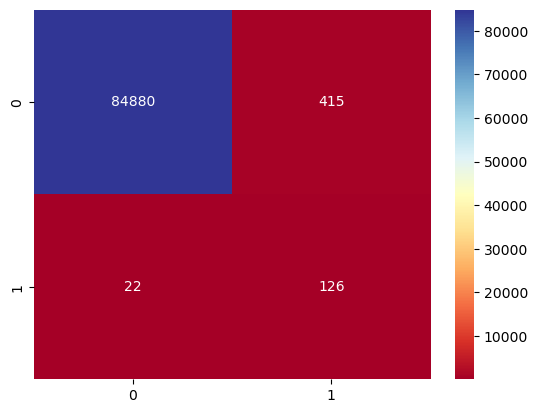

In [22]:
cm_LGR = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_LGR)
sns.heatmap(cm_LGR, annot=True, cmap=COLOR_MAP, fmt=".0f");

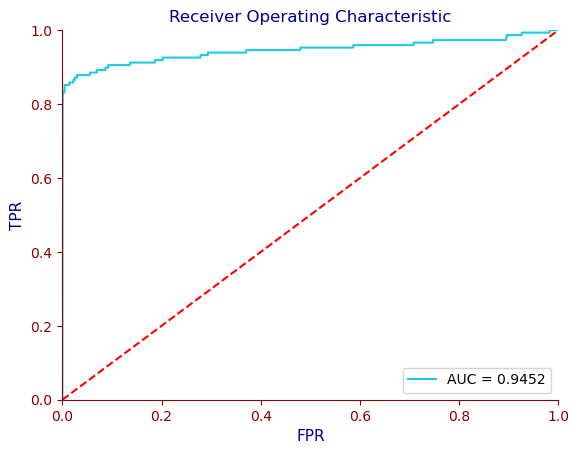

In [23]:
fpr_LGR, tpr_LGR, _ = metrics.roc_curve(y_test, y_prob_LGR[:, 1])
roc_auc_LGR = metrics.auc(fpr_LGR, tpr_LGR)
plot_roc(fpr_LGR, tpr_LGR, roc_auc_LGR)

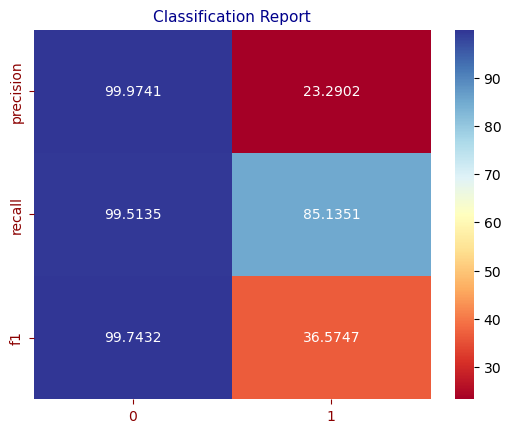

In [24]:
plot_classification(y_true=y_test, y_pred=y_pred_LGR)

In [25]:
metrics.accuracy_score(y_true=y_test, y_pred=y_pred_LGR)

0.9948854792083611

## Random Forest Classifier

In [26]:
param_grid_RFC = {
}

model_RFC = RandomForestClassifier(
    n_estimators=20,
    class_weight="balanced",
    n_jobs=N_JOBS,
    random_state=N_SEED,
    verbose=VERBOSE,
)

grid_search_cv_RFC = GridSearchCV(
    model_RFC,
    param_grid=param_grid_RFC,
    refit=True,
)

pipeline_RFC = make_pipeline(
    grid_search_cv_RFC,
)

model_RFC.fit(X_train, y_train,)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   14.8s finished


RandomForestClassifier(class_weight='balanced', n_estimators=20, n_jobs=4,
                       random_state=19, verbose=1)

In [27]:
y_pred_RFC = model_RFC.predict(X_test)
y_prob_RFC = model_RFC.predict_proba(X_test) * 100

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished


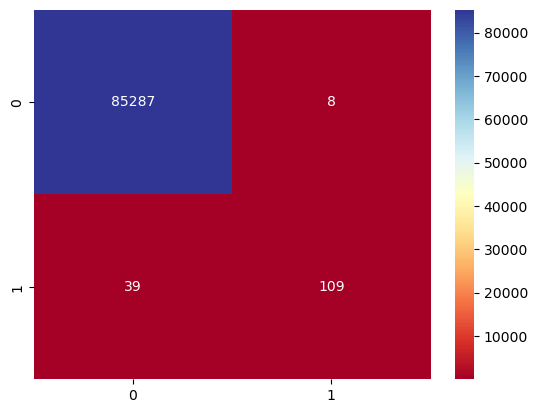

In [28]:
cm_RFC = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_RFC)
sns.heatmap(cm_RFC, annot=True, cmap=COLOR_MAP, fmt=".0f");

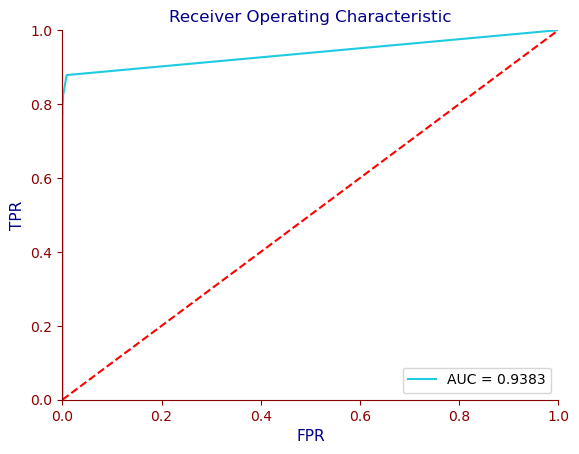

In [29]:
fpr_RFC, tpr_RFC, _ = metrics.roc_curve(y_test, y_prob_RFC[:, 1])
roc_auc_RFC = metrics.auc(fpr_RFC, tpr_RFC)
plot_roc(fpr_RFC, tpr_RFC, roc_auc_RFC)

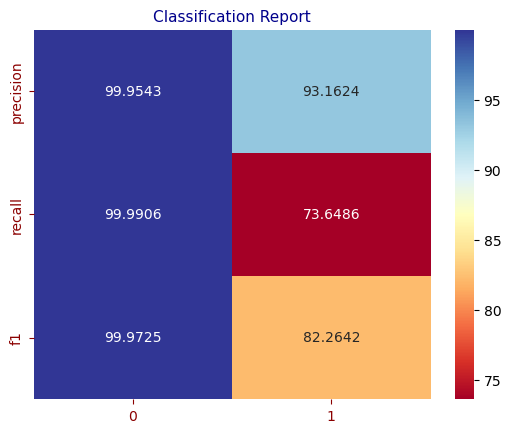

In [30]:
plot_classification(y_true=y_test, y_pred=y_pred_RFC)

In [31]:
metrics.accuracy_score(y_true=y_test, y_pred=y_pred_RFC)

0.9994499256814484

## XGBoost

In [32]:
params_XGB = {
    "n_jobs": N_JOBS,
    "verbosity": VERBOSE,
}

param_grid_XGB = {
    "eta": [0.3, 0.5],
    "max_depth": [6, 8, 10]
}

model_XGB = XGBClassifier(**params_XGB)

grid_search_cv_XGB = GridSearchCV(
    model_XGB,
    param_grid=param_grid_XGB,
    refit=True,
)

pipeline_XGB = make_pipeline(
    grid_search_cv_XGB,
)

pipeline_XGB.fit(X_train, y_train)

Pipeline(steps=[('gridsearchcv',
                 GridSearchCV(estimator=XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_type=None,
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_bin=None,
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=4,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...),
                              param_grid={'eta': [0.3, 0.5],
                                          'max_depth': [6, 8, 10]}))])

In [33]:
y_pred_XGB = pipeline_XGB.predict(X_test)
y_prob_XGB = pipeline_XGB.predict_proba(X_test) * 100


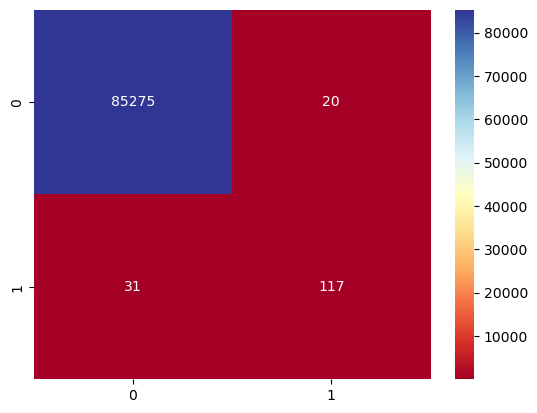

In [34]:
cm_XGB = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_XGB)
sns.heatmap(cm_XGB, annot=True, cmap=COLOR_MAP, fmt=".0f");

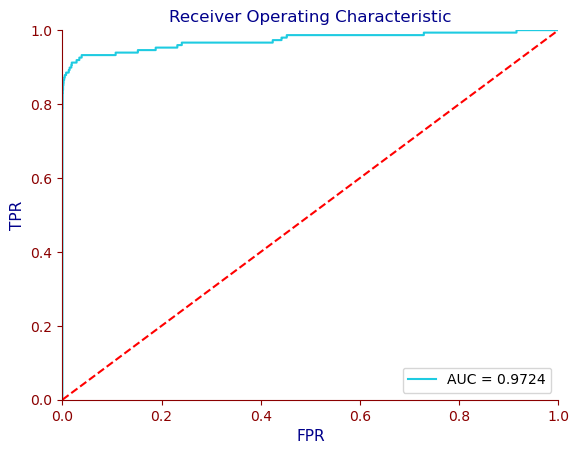

In [35]:
fpr_XGB, tpr_XGB, _ = metrics.roc_curve(y_test, y_prob_XGB[:, 1])
roc_auc_XGB = metrics.auc(fpr_XGB, tpr_XGB)
plot_roc(fpr_XGB, tpr_XGB, roc_auc_XGB)

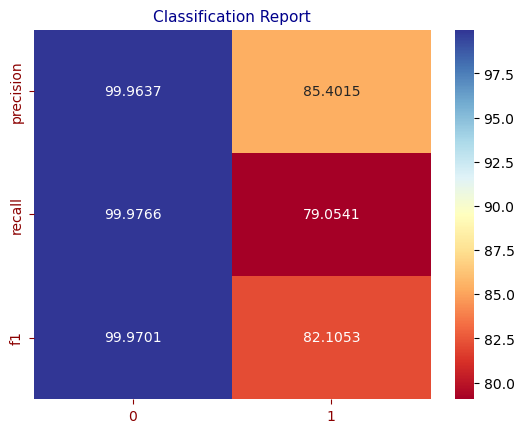

In [36]:
plot_classification(y_true=y_test, y_pred=y_pred_XGB)

In [37]:
metrics.accuracy_score(y_true=y_test, y_pred=y_pred_XGB)

0.999403110845827

In [38]:
model_HGBC = HistGradientBoostingClassifier(
    random_state=N_SEED,
    verbose=VERBOSE,
)

param_grid_HGBC = {
}

grid_search_cv_HGBC = GridSearchCV(
    model_HGBC,
    param_grid=param_grid_HGBC,
    refit=True,
)

pipeline_HGBC = make_pipeline(
    grid_search_cv_HGBC,
)

pipeline_HGBC.fit(X_train, y_train)

Binning 0.066 GB of training data: 0.800 s
Binning 0.007 GB of validation data: 0.010 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 22, train loss: 0.59838, val loss: 0.59835, in 0.018s
[2/100] 1 tree, 31 leaves, max depth = 22, train loss: 0.52078, val loss: 0.52070, in 0.020s
[3/100] 1 tree, 31 leaves, max depth = 22, train loss: 0.45607, val loss: 0.45597, in 0.021s
[4/100] 1 tree, 31 leaves, max depth = 22, train loss: 0.40135, val loss: 0.40122, in 0.021s
[5/100] 1 tree, 31 leaves, max depth = 22, train loss: 0.35461, val loss: 0.35446, in 0.021s
[6/100] 1 tree, 31 leaves, max depth = 23, train loss: 0.31436, val loss: 0.31418, in 0.018s
[7/100] 1 tree, 31 leaves, max depth = 21, train loss: 0.27946, val loss: 0.27925, in 0.019s
[8/100] 1 tree, 31 leaves, max depth = 21, train loss: 0.24898, val loss: 0.24876, in 0.020s
[9/100] 1 tree, 31 leaves, max depth = 19, train loss: 0.22220, val loss: 0.22200, in 0.020s
[10/100] 1 tree, 31 leaves, max depth = 21

Pipeline(steps=[('gridsearchcv',
                 GridSearchCV(estimator=HistGradientBoostingClassifier(random_state=19,
                                                                       verbose=1),
                              param_grid={}))])

In [39]:
y_pred_HGBC = pipeline_HGBC.predict(X_test)
y_prob_HGBC = pipeline_HGBC.predict_proba(X_test) * 100

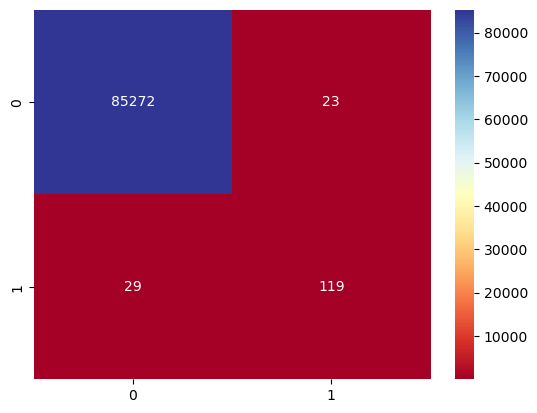

In [40]:
cm_HGBC = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_HGBC)
sns.heatmap(cm_HGBC, annot=True, cmap=COLOR_MAP, fmt=".0f");

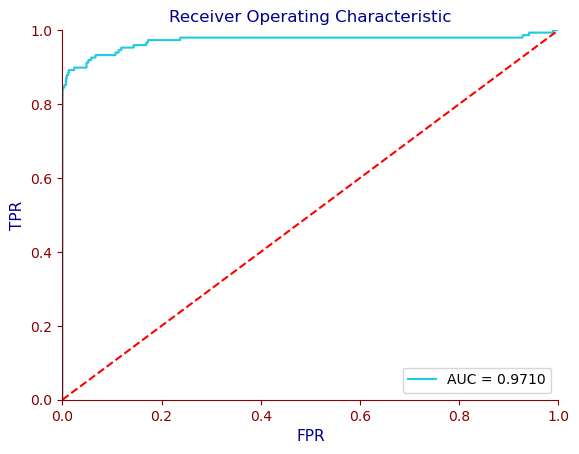

In [41]:
fpr_HGBC, tpr_HGBC, _ = metrics.roc_curve(y_test, y_prob_HGBC[:, 1])
roc_auc_HGBC = metrics.auc(fpr_HGBC, tpr_HGBC)
plot_roc(fpr_HGBC, tpr_HGBC, roc_auc_HGBC)

In [42]:
metrics.accuracy_score(y_true=y_test, y_pred=y_pred_HGBC)

0.9993914071369217